In [1]:
import cv2
import numpy as np
from  matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# 讀取圖檔
img = cv2.imread('lena.bmp')
s = img.shape
block_size = 8

(512, 512, 3)


In [3]:
s = img.shape
bn = np.zeros(img.shape)
for i in range(s[2]):
    for j in range(s[0]):
        for k in range(s[1]):
            if img[j,k,i]>127:
                bn[j,k,i] = 255
            else:
                bn[j,k,i] = 0

In [4]:
def downsample(img, block_size):
    s = img.shape
    row = int(s[0]/block_size)
    col = int(s[1]/block_size)
    ds = np.zeros((row, col, s[2]))
    for i in range(row):
        for j in range(col):
            ds[i, j, 0] = img[i*block_size, j*block_size, 0] 
            ds[i, j, 1] = img[i*block_size, j*block_size, 1] 
            ds[i, j, 2] = img[i*block_size, j*block_size, 2] 
    return ds

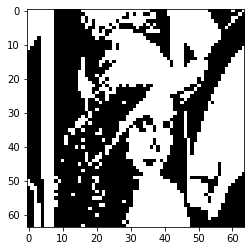

In [5]:
down_sample = downsample(bn, block_size)
plt.imshow(down_sample.astype('uint8'))
plt.show()

In [6]:
def yokoi_four_connectivity(img):
    img_pad = np.pad(array=img, pad_width=((1,1),(1,1),(0,0)), mode='constant', constant_values=0)
    img_size = img.shape
    img_tmp = np.zeros(img_size)
    for i in range(1,img_size[0]+1): #1~
        for j in range(1,img_size[1]+1): #1~
            if img_pad[i, j, 0] != 0:
                #1.find q r s
                label = []
                #左
                if img_pad[i, j, 0] != img_pad[i, j-1, 0]:
                    label.append('s')
                else:
                    if img_pad[i-1, j-1, 0] != img_pad[i-1, j, 0]:
                        label.append('q')
                    else:
                        if img_pad[i-1, j-1, 0] > 0:
                            label.append('r')
                        else:
                            label.append('q')
                #上
                if img_pad[i, j, 0] != img_pad[i-1, j, 0]:
                    label.append('s')
                else:
                    if img_pad[i-1, j+1, 0] != img_pad[i, j+1, 0]:
                        label.append('q')
                    else:
                        if img_pad[i-1, j+1, 0] > 0:
                            label.append('r')
                        else:
                            label.append('q')
                #右
                if img_pad[i, j, 0] != img_pad[i, j+1, 0]:
                    label.append('s')
                else:
                    if img_pad[i+1, j+1, 0] != img_pad[i+1, j, 0]:
                        label.append('q')
                    else:
                        if img_pad[i+1, j+1, 0] > 0:
                            label.append('r')
                        else:
                            label.append('q')
                #下
                if img_pad[i, j, 0] != img_pad[i+1, j, 0]:
                    label.append('s')
                else:
                    if img_pad[i+1, j-1, 0] != img_pad[i, j-1, 0]:
                        label.append('q')
                    else:
                        if img_pad[i+1, j-1, 0] > 0:
                            label.append('r')
                        else:
                            label.append('q')
                        
                #2.Yokoi Connectivity Number
                if label.count('r') == 4:
                    img_tmp[i-1, j-1, 0] = 5
                    img_tmp[i-1, j-1, 1] = 5
                    img_tmp[i-1, j-1, 2] = 5
                else:
                    c = label.count('q')
                    img_tmp[i-1, j-1, 0] = c
                    img_tmp[i-1, j-1, 1] = c
                    img_tmp[i-1, j-1, 2] = c
    return img_tmp.astype('uint8')
                    

In [7]:
#64x64x3
yfc = yokoi_four_connectivity(down_sample)
yfc_size = yfc.shape

In [8]:
def pair_relation(yfc):
    yfc_size = yfc.shape
    #print(yfc_size)
    # 66x66
    h = np.zeros((int(yfc_size[0]+2),int(yfc_size[1])+2)) #pad
    # "1" means "edge"
    for i in range(1,yfc_size[0]+1):
        for j in range(1,yfc_size[1]+1):
            if yfc[i-1, j-1, 0] == 1:
                h[i, j] = 1
            else:
                h[i, j] = 0
    #mark p q 64x64
    y = [ ["" for i in range(yfc_size[1])] for j in range(yfc_size[0]) ]
    y = np.array(y)
    for i in range(1,yfc_size[0]+1):
        for j in range(1,yfc_size[1]+1):
            if yfc[i-1, j-1, 0] != 0:
                h_sum = h[i-1,j]+h[i,j+1]+h[i+1,j]+h[i,j-1]
                if h_sum < 1 or h[i,j] != 1:
                    y[i-1,j-1] = 'q'
                elif h_sum >= 1 and h[i,j] == 1:
                    y[i-1,j-1] = 'p'
                else:
                    y[i-1,j-1] = ' '
            else:
                y[i-1,j-1] = ' '
                
    return y

In [11]:
#mark p q 64x64
y = pair_relation(yfc,downsample)
#print(y.shape)

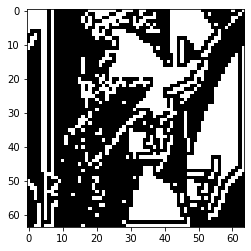

In [12]:
down_sample_tmp = np.pad(array=down_sample, pad_width=((1,1),(1,1),(0,0)), mode='constant', constant_values=0)
for i in range(1,yfc_size[0]+1):
    for j in range(1,yfc_size[1]+1):
        if y[i-1,j-1] == 'p':
            dst = yokoi_four_connectivity(down_sample_tmp[i-1:i+2,j-1:j+2,:])
            if dst[1,1,0] == 1:
                down_sample_tmp[i,j,0] = 0
                down_sample_tmp[i,j,1] = 0
                down_sample_tmp[i,j,2] = 0
            
plt.imshow(down_sample_tmp[1:65,1:65,:].astype('uint8'))
plt.show()

In [12]:
def thinning(downsample,iter=1):
    ds_thin = downsample
    for i in range(iter):
        #64x64x3
        yfc = yokoi_four_connectivity(ds_thin)
        yfc_size = yfc.shape
        #mark p q 64x64
        y = pair_relation(yfc)
        tmp = np.pad(array=ds_thin, pad_width=((1,1),(1,1),(0,0)), mode='constant', constant_values=0)
        for i in range(1,yfc_size[0]+1):
            for j in range(1,yfc_size[1]+1):
                if y[i-1,j-1] == 'p':
                    dst = yokoi_four_connectivity(tmp[i-1:i+2,j-1:j+2,:])
                    if dst[1,1,0] == 1:
                        tmp[i,j,0] = 0
                        tmp[i,j,1] = 0
                        tmp[i,j,2] = 0
        ds_thin = tmp[1:65,1:65,:]
    return ds_thin

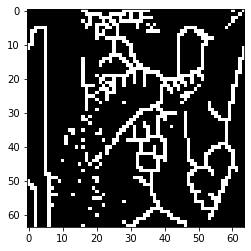

In [13]:
ans = thinning(down_sample,7)

plt.imshow(ans.astype('uint8'))
plt.show()

In [9]:
test = np.array([[[0,0,0],[1,1,0],[1,1,0]],[[0,0,0],[1,1,0],[1,1,0]],[[0,0,0],[1,1,0],[1,1,0]]])
ty = yokoi_four_connectivity(test)
print(ty)

[[[0 0 0]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [1 1 1]
  [1 1 1]]]
